In [1]:
#configure dataset
from os import listdir

directory_name = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
image_names = listdir(directory_name)
image_names.remove('.DS_Store')
print(image_names[:5])

['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


In [2]:
#calculate mean width and lenght
import os, random
from scipy.misc import imread, imresize

width = 0
lenght = 0
images_size = len(image_names)

for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//images_size
lenght_mean = lenght//images_size
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 152
Lenght mean: 147
Size mean dimension: 149


In [3]:
#(149, 147), so we can redefine as (150, 150)
dim_size = 150

In [4]:
#load images
import matplotlib.pyplot as plt

#resizing and labeling
images = []
labels = []
for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    image = imresize(image, (dim_size, dim_size))
    images.append(image)
    label = image_names[i].split('_')[:-1]
    labels.append('_'.join(label))

print("Loaded {} test images".format(len(images)))

Loaded 990 test images


Label:homer_simpson, Image:350, Shape:(150, 150, 3)


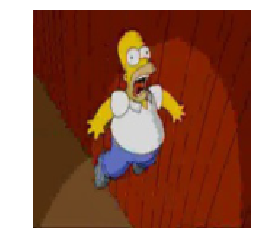

Label:marge_simpson, Image:611, Shape:(150, 150, 3)


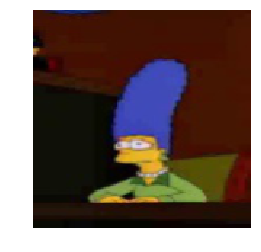

Label:lisa_simpson, Image:556, Shape:(150, 150, 3)


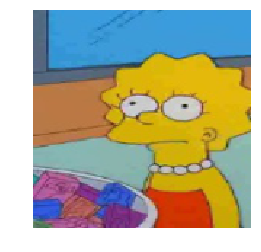

In [5]:
#show some examples
for i in range(0,3):
    idx = random.randint(0, images_size)
    image = images[idx]
    print("Label:{}, Image:{}, Shape:{}".format(labels[idx], idx, image.shape))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
#normalize data
import numpy as np

def normalize(x):
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

images_norm = []

for i in range(0, images_size):
    images_norm.append(normalize(images[i]))
    
print(images_norm[1])

[[[ 0.14814815  0.42798354  0.58847737]
  [ 0.15226337  0.43209877  0.59259259]
  [ 0.15226337  0.43209877  0.58436214]
  ..., 
  [ 0.65843621  0.68312757  0.64197531]
  [ 0.65843621  0.67901235  0.65020576]
  [ 0.65432099  0.68312757  0.65020576]]

 [[ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58024691]
  ..., 
  [ 0.65843621  0.67901235  0.65432099]
  [ 0.65432099  0.68312757  0.65432099]
  [ 0.65432099  0.68312757  0.65432099]]

 [[ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58024691]
  ..., 
  [ 0.65843621  0.67489712  0.67078189]
  [ 0.65432099  0.67901235  0.67078189]
  [ 0.65432099  0.67901235  0.66666667]]

 ..., 
 [[ 0.41152263  0.18930041  0.0781893 ]
  [ 0.41152263  0.18930041  0.07407407]
  [ 0.41152263  0.18930041  0.07407407]
  ..., 
  [ 0.41152263  0.19341564  0.06584362]
  [ 0.41152263  0.19341564  0.06995885]
  [ 0.41563786  0.19341564  0.07818

In [7]:
#one-hot encode
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb = lb.fit(labels)
labels_one_hot = lb.transform(labels)

#show one-hot labels
print(lb.classes_)

#example
code = lb.transform(['marge_simpson'])
print(code)
print(lb.inverse_transform(code))


['abraham_grampa_simpson' 'apu_nahasapeemapetilon' 'bart_simpson'
 'charles_montgomery_burns' 'chief_wiggum' 'comic_book_guy'
 'edna_krabappel' 'homer_simpson' 'kent_brockman' 'krusty_the_clown'
 'lenny_leonard' 'lisa_simpson' 'marge_simpson' 'mayor_quimby'
 'milhouse_van_houten' 'moe_szyslak' 'ned_flanders' 'nelson_muntz'
 'principal_skinner' 'sideshow_bob']
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
['marge_simpson']


In [8]:
#images_norm: has the list of normalized images
#labels_one_hot: has the list of one-hot encoded labels

images_norm = np.array(images_norm)
labels_one_hot = np.array(labels_one_hot)

print("Images shape:{}".format(images_norm.shape[1:]))
print("Labels shape:{}".format(labels_one_hot.shape[1:]))

Images shape:(150, 150, 3)
Labels shape:(20,)


In [29]:
import tensorflow as tf

#helpers
def convolution(inputs, kernel_shape, stride_shape, output_depth):
    #convolution variables
    input_depth = inputs.get_shape().as_list()[3]
    filter_shape = kernel_shape + (input_depth, output_depth)
    dev = 1/np.sqrt(kernel_shape[0]*kernel_shape[1])
    filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=dev), name="filter_")
    stride_shape = (1,) + stride_shape + (1,)
    pool_shape = stride_shape
    bias_ = tf.Variable(tf.truncated_normal([output_depth], stddev=dev), name="bias_")
    
    #convolution
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    #conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    #conv = tf.nn.bias_add(conv, bias_)
    #conv = tf.nn.relu(conv)
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    
    #pooling
    conv = tf.nn.max_pool(conv, pool_shape, stride_shape, padding='SAME')
    
    return conv

def classifier(inputs, num_outputs):
    #classifier variables
    num_inputs = inputs.get_shape().as_list()[1]
    dev = 1/np.sqrt(num_inputs)
    weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=dev), name="weights")
    bias = tf.Variable(tf.truncated_normal(num_outputs, stddev=dev), name="bias")

    #classifier
    logits = tf.add(tf.matmul(inputs, weights), bias)

    return logits

In [30]:
##building the network
#remove previous weights, bias, etc
tf.reset_default_graph()

#data
X = tf.placeholder(tf.float32, (None,) + images_norm.shape[1:])
y = tf.placeholder(tf.float32, (None,) + labels_one_hot.shape[1:])

#conv
print(X.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 16)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 32)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 64)
print(conv.get_shape().as_list())
    
#before classifier
flatten_shape = np.prod(conv.get_shape().as_list()[1:])
flatten = tf.reshape(conv, [-1,flatten_shape])

#classifying
num_outputs = labels_one_hot.shape[1:]

logits = classifier(flatten, num_outputs)

print("Inputs shape: {}".format(X.get_shape().as_list()[1:]))
print("Flatten shape: {}".format(flatten_shape))
print("Outputs shape: {}".format(logits.get_shape().as_list()[1]))

[None, 150, 150, 3]
[None, 38, 38, 16]
[None, 10, 10, 32]
[None, 3, 3, 64]
Inputs shape: [150, 150, 3]
Flatten shape: 576
Outputs shape: 20


In [31]:
#loss and optmizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [32]:
#obtaining batch with random data from dataset
def get_batches(x, y, size):
    idx = np.random.randint(x.shape[0], size=size)
    x_batch, y_batch = x[idx,:], y[idx,:]
    
    return x_batch, y_batch

In [34]:
##Train the model
x_train = []
y_train = []
x_val = []
y_val = []

#train and validation
for i in range(images_norm.shape[0]):
    r = random.random()
    if (r < 0.8):
        x_train.append(images_norm[i])
        y_train.append(labels_one_hot[i])
    else:
        x_val.append(images_norm[i])
        y_val.append(labels_one_hot[i])

x_train = np.array(x_train)
y_train = np.array(y_train)

##
epochs = 100
batch_size = 256

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    x_batch, y_batch = get_batches(x_train, y_train, batch_size)
    feed_dict = {X:x_batch, y:y_batch}
    sess.run(optimizer, feed_dict)
    loss, acc = sess.run([cost, accuracy], feed_dict)
    print("Epoch:{} Loss:{:.4f} Accuracy:{:.4f}".format(e, loss, acc))

Epoch:0 Loss:5.4546 Accuracy:0.0820
Epoch:1 Loss:4.4823 Accuracy:0.0391
Epoch:2 Loss:3.9164 Accuracy:0.0586
Epoch:3 Loss:3.8290 Accuracy:0.0352
Epoch:4 Loss:3.9965 Accuracy:0.0508
Epoch:5 Loss:3.8642 Accuracy:0.0664
Epoch:6 Loss:3.7803 Accuracy:0.0625
Epoch:7 Loss:3.6026 Accuracy:0.0547
Epoch:8 Loss:3.6570 Accuracy:0.0508
Epoch:9 Loss:3.4633 Accuracy:0.0664
Epoch:10 Loss:3.2779 Accuracy:0.0781
Epoch:11 Loss:3.1817 Accuracy:0.0703
Epoch:12 Loss:3.2213 Accuracy:0.0781
Epoch:13 Loss:3.1436 Accuracy:0.1133
Epoch:14 Loss:3.0520 Accuracy:0.0898
Epoch:15 Loss:2.9919 Accuracy:0.0742
Epoch:16 Loss:3.0731 Accuracy:0.0430
Epoch:17 Loss:3.0087 Accuracy:0.0547
Epoch:18 Loss:2.9649 Accuracy:0.0820
Epoch:19 Loss:2.8977 Accuracy:0.0977
Epoch:20 Loss:2.8940 Accuracy:0.1094
Epoch:21 Loss:2.8707 Accuracy:0.0938
Epoch:22 Loss:2.8652 Accuracy:0.1406
Epoch:23 Loss:2.9078 Accuracy:0.1250
Epoch:24 Loss:2.8259 Accuracy:0.1602
Epoch:25 Loss:2.7876 Accuracy:0.1562
Epoch:26 Loss:2.8443 Accuracy:0.1445
Epoch:27 Lo

In [75]:
#prediction
idx = int(random.uniform(0, len(y_val)))
    
image_sample = x_val[idx]
label_sample = y_val[idx]
prediction = sess.run(logits, {X:[image_sample], y:[label_sample]})

prediction = lb.inverse_transform(prediction)

#showing
#image = images[idx]
lbl = np.array([label_sample])
lbl = lb.inverse_transform(lbl)
print("Label:{}".format(lbl))
print("Prediction: {}".format(prediction))

plt.imshow(image_sample)
plt.axis('off')
plt.show()

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(?, 150, 150, 3), dtype=float32) is not an element of this graph.